In [ ]:
!pip install kagglehub[pandas-datasets]

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

In [ ]:
!pwd

/content


In [ ]:
print(path)

/kaggle/input/chest-xrays-indiana-university


In [ ]:
import numpy as np
import cv2
import pandas as pd
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import itertools
import torch.optim as optim
import torch.nn.functional as F
import math

from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# read and process files

In [ ]:
# df_projections = pd.read_csv('/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/indiana_projections.csv')
df_projections = pd.read_csv(f'{path}/indiana_projections.csv')
df_reports = pd.read_csv('./indiana_reports_labeled.csv')

In [ ]:
df_reports.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,Cardiomegaly,Pulmonary Atelectasis,...,Thickening,Hernia,Pulmonary Edema,Pneumonia,Consolidation,Pneumothorax,Fibrosis,Mass,Granuloma,Normal
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,0,0,...,1,0,0,0,0,0,0,0,0,0


merge report table and projection table

In [ ]:
# all label columns (15 diseases + Normal)
label_columns = [
    "Cardiomegaly", "Pulmonary Atelectasis", "Pleural Effusion", "Nodule",
    "Infiltrate", "Emphysema", "Thickening", "Hernia", "Pulmonary Edema",
    "Pneumonia", "Consolidation", "Pneumothorax", "Fibrosis", "Mass",
    "Granuloma", "Normal"
]

# rows that have at least one label equal to 1
df_reports = df_reports[df_reports[label_columns].sum(axis=1) > 0]

merged_df = pd.merge(df_projections, df_reports, on='uid', how='inner')
merged_df = merged_df.rename(columns={'filename': 'image_path', 'findings': 'report'})
merged_df = merged_df.dropna(subset=['report'])

print("patient count:", len(merged_df))
print("distinct UID count:", merged_df['uid'].nunique())

image_counts = merged_df['uid'].value_counts()
print("count of figures for each patient:")
print(image_counts.describe())

patient count: 4497
distinct UID count: 2307
count of figures for each patient:
count    2307.000000
mean        1.949285
std         0.416000
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: count, dtype: float64


length of report:
count    4497.000000
mean       30.530131
std        14.685767
min         7.000000
25%        20.000000
50%        28.000000
75%        37.000000
max       169.000000
Name: number_of_words, dtype: float64


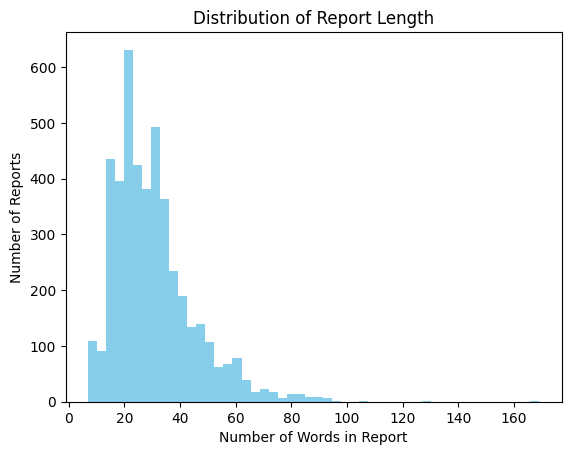

In [ ]:
merged_df['number_of_words'] = merged_df['report'].apply(lambda text: len(str(text).split()))
merged_df['number_of_words'] = merged_df['number_of_words'].astype(int)

print("length of report:")
print(merged_df['number_of_words'].describe())

import matplotlib.pyplot as plt
plt.hist(merged_df['number_of_words'], bins=50, color='skyblue')
plt.xlabel('Number of Words in Report')
plt.ylabel('Number of Reports')
plt.title('Distribution of Report Length')
plt.show()

因为一个uid可能有两张图片，如果纯粹随机分配test和train可能出现一个人一张图片在train里面，一张在test里面，这会影响validility
所以先随机分配uid,将同一个uid的对应的所有图片作为test或者train中的一部分

In [ ]:
images_report_df = merged_df[['uid', 'image_path', 'report', 'number_of_words'] + label_columns].reset_index(drop=True)
image_folder = '/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized'
image_filenames = images_report_df.image_path.values

# get distinct uid to split train and test
unique_uids = images_report_df['uid'].unique()
train_uids, test_uids = train_test_split(unique_uids, test_size=0.2, random_state=42)

# split
train_captions = images_report_df[images_report_df['uid'].isin(train_uids)].reset_index(drop=True)
test_captions = images_report_df[images_report_df['uid'].isin(test_uids)].reset_index(drop=True)

print("Train shape:", train_captions.shape)
print("Test shape:", test_captions.shape)
print(f"Unique UIDs in train: {train_captions['uid'].nunique()}, in test: {test_captions['uid'].nunique()}")


Train shape: (3595, 20)
Test shape: (902, 20)
Unique UIDs in train: 1845, in test: 462


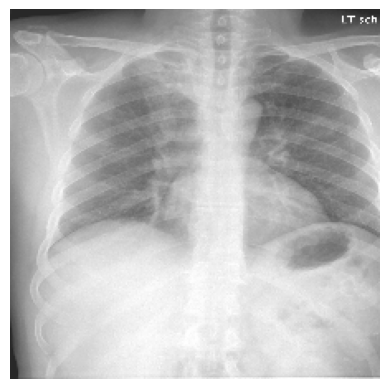

(224, 224, 3)


In [ ]:
batch_size = 16
image_size = 224

def preprocess_image(image_path, image_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def display_image(image_np):
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()
image = preprocess_image(f"{path}/images/images_normalized/1000_IM-0003-1001.dcm.png",image_size)
display_image(image)
print(image.shape)

# before training

## image preprocessing

In [ ]:
num_processors = os.cpu_count()
print(num_processors)

#normalize image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class ImageTextDataset(Dataset): # construct train dataset
  def __init__(self, image_filenames, text_list, image_size=224, transform=transform):
      self.image_filenames = image_filenames
      self.text_list = text_list  #report
      self.image_size = image_size
      self.transform = transform or transforms.ToTensor()

  def __len__(self):
      return len(self.image_filenames)

  def __getitem__(self, idx):
      image_path = f"{path}/images/images_normalized/{self.image_filenames[idx]}"
      image = preprocess_image(image_path, self.image_size)
      image = self.transform(image)
      text = self.text_list[idx]
      return image, text



2


In [ ]:
# For train
train_dataset = ImageTextDataset(train_captions.image_path.values, train_captions.report.values,image_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(train_dataset. __getitem__(0)[0].shape)

torch.Size([3, 224, 224])


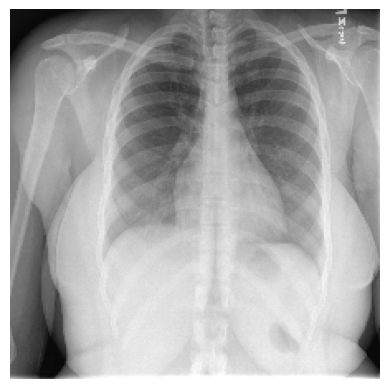

Report: Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.



In [ ]:
images_batch, reports_batch = next(iter(train_dataloader))

image1 = images_batch[0].permute(1, 2, 0).numpy()
report1 = reports_batch[0]

display_image(image1)
print(f"Report: {report1}\n")

# CLIP setting

In [ ]:
dropout = 0.1
class ImageProjection(nn.Module):
  def __init__(self, image_embedding_size, shared_embedding_size):
    super(ImageProjection, self).__init__()
    self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
    self.gelu = nn.GELU()
    self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(shared_embedding_size)

  def forward(self, image_embeddings):
    projected_embeddings = self.image_projection(image_embeddings)

    x = self.gelu(projected_embeddings)
    x = self.fc(x)
    x = self.dropout(x)
    x = x + projected_embeddings
    x = self.layer_norm(x)

    return x

class TextProjection(nn.Module):
  def __init__(self, text_embedding_size, shared_embedding_size):
      super(TextProjection, self).__init__()
      self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
      self.gelu = nn.GELU()
      self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
      self.dropout = nn.Dropout(dropout)
      self.layer_norm = nn.LayerNorm(shared_embedding_size)

  def forward(self, text_embeddings):
      projected_embeddings = self.text_projection(text_embeddings)

      x = self.gelu(projected_embeddings)
      x = self.fc(x)
      x = self.dropout(x)
      x = x + projected_embeddings
      x = self.layer_norm(x)

      return x

batch_idx:  0  Image Shape:  torch.Size([16, 3, 224, 224]) Text Count:  16


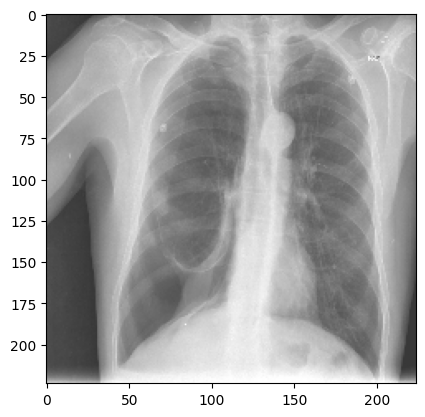

A large pleural air collection is present on the right. Mediastinum is shifted to the left as compared to the previous examination. The right lower lobe is totally opaque.


In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

for batch_idx, (images, texts) in enumerate(train_dataloader):
  print( "batch_idx: ", batch_idx, " Image Shape: ", images.shape, "Text Count: ", len(texts) )
  plt.imshow( torch.moveaxis( images[0], 0, 2 ).numpy() )
  plt.show()
  print(texts[0])
  break

In [ ]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = 2

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
  logits = (text_projection @ image_projection.T) / temperature_value
  if mode=="train":
      images_similarity = image_projection @ image_projection.T
      texts_similarity = text_projection @ text_projection.T
      targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
      texts_loss = cross_entropy(logits, targets, reduction='none')
      images_loss = cross_entropy(logits.T, targets.T, reduction='none')
      loss =  (images_loss + texts_loss) / 2.0
      return loss.mean()
  elif mode=="eval":
      return logits
  else:
      print("Mention mode")
      return None

# Train CLIP

In [ ]:
def count_trainable_parameters(model):
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return trainable_params

In [ ]:
from transformers import AutoTokenizer, AutoModel
shared_embedding_size = 512
# - - - - - - - - - ResNet Model - - - - - - - - -
# Load a pre-trained ResNet model
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
# Remove the classification layer (the last fully connected layer)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
print(" Number of Trainable Parameters in", " ResNet50 Model :  ",   count_trainable_parameters(resnet_model))
# - - - - - - - - -  Bio_ClinicalBERT  - - - - - - - - -
max_length = 200
text_embedding_size = 768
model_name='emilyalsentzer/Bio_ClinicalBERT'
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)
print(" Number of Trainable Parameters in", " Bio_ClinicalBERT model :  ",   count_trainable_parameters(text_model))

 Number of Trainable Parameters in  ResNet50 Model :   23508032


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

 Number of Trainable Parameters in  Bio_ClinicalBERT model :   108310272


In [ ]:
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

 Number of Trainable Parameters in  Image Projection :   1312768
 Number of Trainable Parameters in  Text Projection :   657408

 - - - - - - - - - - 
 
  Training......  


In [ ]:
optimizer = optim.AdamW([
    {"params": resnet_model.parameters(), "lr": 1e-4},
    {"params": text_model.parameters(), "lr": 1e-5},
    {"params": image_projector.parameters(), "lr": 1e-3},
    {"params": text_projector.parameters(), "lr": 1e-3},
    ], weight_decay=1e-3)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )
# - - - - - - - - -  Training loop  - - - - - - - - -
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0

    for batch_idx, (images, texts) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # Text
        inputs = text_tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :]
        text_projection = text_projector(text_embeddings)

        # get image embedding
        images = images.to(device)
        image_embeddings = resnet_model(images)
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)
        image_projection = image_projector(image_embeddings)

        # - - - -  Compute Loss  - - - -
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")

    # - - - - Loss each epoch
    lr_scheduler.step(total_loss)
    end_time = time.time()
    elapsed_time = end_time - start_time
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds")

 - - - - - - - - - - - Epoch: 1  - - - - - - - - - - - - 
Epoch [1/10], Batch [0/225], Loss: 0.6159
Epoch [1/10], Batch [200/225], Loss: 0.2421
Epoch [1/10], Average Loss: 3.7624   Time Taken:  387.5888903141022  seconds
 - - - - - - - - - - - Epoch: 2  - - - - - - - - - - - - 
Epoch [2/10], Batch [0/225], Loss: 0.1760
Epoch [2/10], Batch [200/225], Loss: 0.1771
Epoch [2/10], Average Loss: 2.8319   Time Taken:  381.3787863254547  seconds
 - - - - - - - - - - - Epoch: 3  - - - - - - - - - - - - 
Epoch [3/10], Batch [0/225], Loss: 0.1763
Epoch [3/10], Batch [200/225], Loss: 0.1761
Epoch [3/10], Average Loss: 2.8149   Time Taken:  353.99156737327576  seconds
 - - - - - - - - - - - Epoch: 4  - - - - - - - - - - - - 
Epoch [4/10], Batch [0/225], Loss: 0.1758
Epoch [4/10], Batch [200/225], Loss: 0.1756
Epoch [4/10], Average Loss: 2.8085   Time Taken:  338.0437321662903  seconds
 - - - - - - - - - - - Epoch: 5  - - - - - - - - - - - - 
Epoch [5/10], Batch [0/225], Loss: 0.1760
Epoch [5/10], B

In [ ]:
torch.save({
    'epoch': epoch,
    'resnet_model': resnet_model.state_dict(),
    'text_model': text_model.state_dict(),
    'image_projector': image_projector.state_dict(),
    'text_projector': text_projector.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': lr_scheduler.state_dict(),
}, "./clip_checkpoint.pth")



# zero-shot prediction

In [ ]:
from transformers import AutoTokenizer, AutoModel
shared_embedding_size = 512
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
max_length = 200
text_embedding_size = 768
model_name='emilyalsentzer/Bio_ClinicalBERT'
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)

checkpoint = torch.load("clip_model.pth")
resnet_model.load_state_dict(checkpoint['resnet_model'])
text_model.load_state_dict(checkpoint['text_model'])
image_projector.load_state_dict(checkpoint['image_projector'])
text_projector.load_state_dict(checkpoint['text_projector'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
class ImageMultiLabelDataset(Dataset): # construct test dataset
  def __init__(self, image_filenames, label_matrix, image_size=224, transform=transform):
      self.image_filenames = image_filenames
      self.label_matrix = label_matrix  # (N, num_labels)
      self.image_size = image_size
      self.transform = transform or transforms.ToTensor()

  def __len__(self):
      return len(self.image_filenames)

  def __getitem__(self, idx):
      image_path = f"{path}/images/images_normalized/{self.image_filenames[idx]}"
      image = preprocess_image(image_path, self.image_size)
      image = self.transform(image)
      labels = self.label_matrix[idx]  # one-hot vector
      return image, torch.tensor(labels, dtype=torch.float32), image_path

test_dataset = ImageMultiLabelDataset(
    image_filenames=test_captions.image_path.values,
    label_matrix=test_captions[label_columns].values,
    image_size=image_size
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_text_features(labels, tokenizer, text_model, text_projector, device):
    prompts = [f"This is a chest X-ray showing {label}." for label in labels]
    encoded = text_tokenizer(prompts, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**encoded)
        text_emb = outputs.last_hidden_state[:, 0, :]
        text_proj = text_projector(text_emb)
        text_proj = F.normalize(text_proj, dim=-1)
    return text_proj

multi-label -- ignore this one. the code is not correct.

In [ ]:
"""from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

def evaluate_zero_shot_multilabel(dataloader, labels, tokenizer, text_model, text_projector,
                                   resnet_model, image_projector, threshold=0.5, device="cuda"):
    text_features = get_text_features(labels, tokenizer, text_model, text_projector, device)
    y_true = []
    y_pred = []

    for images, label_vectors in tqdm(dataloader):
        # Image encoding
        images = images.to(device)
        with torch.no_grad():
            image_embeddings = resnet_model(images).view(images.size(0), -1)
            image_proj = image_projector(image_embeddings)
            image_proj = F.normalize(image_proj, dim=-1)

        # Similarity → probability
        sims = image_proj @ text_features.T  # (batch_size, num_labels)
        probs = torch.sigmoid(sims)  # map similarity to (0, 1)

        preds = (probs > threshold).int().cpu().numpy()
        labels_true = label_vectors.cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels_true)

    return np.array(y_true), np.array(y_pred)
y_true, y_pred = evaluate_zero_shot_multilabel(
    test_dataloader, labels=label_columns,
    tokenizer=text_tokenizer, text_model=text_model, text_projector=text_projector,
    resnet_model=resnet_model, image_projector=image_projector,
    threshold=0.5, device=device
)

print(classification_report(y_true, y_pred, target_names=label_columns, zero_division=0))
"""

one label predict

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_zero_shot_top1_soft(dataloader, labels, tokenizer, text_model, text_projector,
                                 resnet_model, image_projector, device="cuda"):
    text_features = get_text_features(labels, tokenizer, text_model, text_projector, device)
    correct = 0
    total = 0

    label_correct_counter = Counter()
    label_total_counter = Counter()

    results = []
    resnet_model.eval()
    image_projector.eval()
    text_projector.eval()
    text_model.eval()

    for images, label_vectors, image_paths in tqdm(dataloader):
        images = images.to(device)

        with torch.no_grad():
            image_embeddings = resnet_model(images).view(images.size(0), -1)
            image_proj = image_projector(image_embeddings)
            image_proj = F.normalize(image_proj, dim=-1)

            sims = image_proj @ text_features.T
            top1_preds = sims.argmax(dim=1).cpu().numpy()

            label_vectors = label_vectors.cpu().numpy()
            true_label_sets = [set(np.where(row == 1)[0]) for row in label_vectors]

            for pred_idx, true_set, img_path in zip(top1_preds, true_label_sets, image_paths):
                total += 1
                pred_label = labels[pred_idx]
                true_label_names = [labels[i] for i in true_set]

                for label in true_set:
                    label_total_counter[label] += 1

                is_correct = int(pred_idx in true_set)
                if is_correct:
                    correct += 1
                    label_correct_counter[pred_idx] += 1

                results.append({
                    "image_path": img_path,
                    "pred_label": pred_label,
                    "true_labels": true_label_names,
                    "correct": is_correct
                })

    label_correct_named = {labels[i]: label_correct_counter[i] for i in label_correct_counter}
    top1_soft_accuracy = correct / total
    print(f"\nTop-1 Soft Accuracy: {top1_soft_accuracy:.4f}")
    print("\nCorrect predictions per label (Top-1 match):")
    for label, count in label_correct_named.items():
        print(f"  {label:25}: {count}")
    result_df = pd.DataFrame(results)
    return top1_soft_accuracy, label_correct_named, result_df


In [ ]:
top1_soft_acc, correct_per_label, result_df = evaluate_zero_shot_top1_soft(
    test_dataloader,
    labels=label_columns,
    tokenizer=text_tokenizer, text_model=text_model, text_projector=text_projector,
    resnet_model=resnet_model, image_projector=image_projector,
    device=device
)

print(result_df.head())
result_df.to_csv("top1_soft_predictions.csv", index=False)


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Top-1 Soft Accuracy: 0.4612

Correct predictions per label (Top-1 match):
  Normal                   : 390
  Granuloma                : 14
  Thickening               : 1
  Pneumonia                : 1
  Cardiomegaly             : 3
  Infiltrate               : 7
                                          image_path pred_label  \
0  /kaggle/input/chest-xrays-indiana-university/i...   Fibrosis   
1  /kaggle/input/chest-xrays-indiana-university/i...     Hernia   
2  /kaggle/input/chest-xrays-indiana-university/i...     Normal   
3  /kaggle/input/chest-xrays-indiana-university/i...     Normal   
4  /kaggle/input/chest-xrays-indiana-university/i...  Granuloma   

                                    true_labels  correct  
0  [Pleural Effusion, Consolidation, Emphysema]        0  
1  [Pleural Effusion, Consolidation, Emphysema]        0  
2                                      [Normal]        1  
3                                      [Normal]        1  
4                                   [E

Grad_CAM

In [ ]:
list(resnet_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

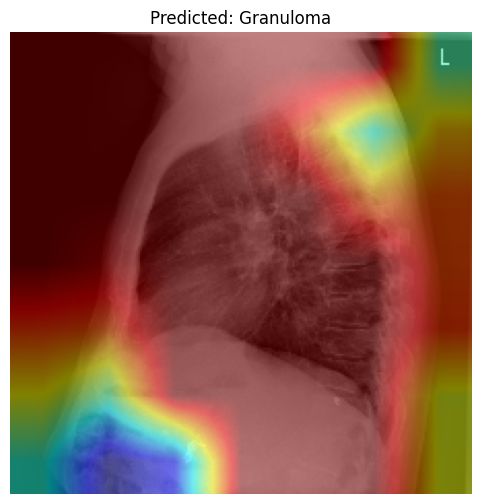

14

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_image_label_with_gradcam(image_path, preprocess_image, transform,
                                     resnet_model, image_projector, labels,
                                     tokenizer, text_model, text_projector,
                                     target_label_idx, device="cuda"):
    text_features = get_text_features(labels, tokenizer, text_model, text_projector, device)
    # Step 1: Hook setup
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Choose target layer
    # target_layer = resnet_model.layer4[-1]
    target_layer = resnet_model[7][-1] # Last block of last layer
    hook_f = target_layer.register_forward_hook(forward_hook)
    hook_b = target_layer.register_full_backward_hook(backward_hook)

    # Preprocess image
    img_np = preprocess_image(image_path, image_size)
    img_tensor = transform(img_np).unsqueeze(0).to(device)

    # Forward pass
    resnet_model.eval()
    image_projector.eval()
    text_projector.eval()
    text_model.eval()
    with torch.enable_grad():
        img_tensor.requires_grad_()
        img_feat_map = resnet_model(img_tensor)               # (1, 2048, 7, 7)
        pooled_feat = img_feat_map.view(1, -1)                # Flatten for projection
        img_proj = image_projector(pooled_feat)
        img_proj = F.normalize(img_proj, dim=-1)

        sim = (img_proj @ text_features.T)  # (1, num_labels)
        pred_label = sim.argmax(dim=1).item()

        # Optionally: choose your own target label index
        target_idx = target_label_idx if target_label_idx is not None else pred_label

        sim[0, target_idx].backward()  # Backprop for specific class

    # Step 2: Get gradients and activations
    grads_val = gradients[0].cpu().data.numpy()[0]           # shape: (C, H, W)
    acts_val = activations[0].cpu().data.numpy()[0]          # shape: (C, H, W)

    # Step 3: Compute Grad-CAM
    weights = np.mean(grads_val, axis=(1, 2))  # average gradient over spatial dims
    cam = np.zeros(acts_val.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts_val[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    cam -= cam.min()
    cam /= cam.max()

    # Step 4: Overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = 0.5 * heatmap + 0.5 * img_np
    save_path = f"./gradcam_{labels[pred_label]}.jpg"
    cv2.imwrite(save_path, overlay.astype(np.uint8))

    # Cleanup
    hook_f.remove()
    hook_b.remove()

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Predicted: {labels[pred_label]}")
    plt.axis('off')
    plt.show()

    return pred_label
predict_image_label_with_gradcam(
    image_path=f"{path}/images/images_normalized/752_IM-2305-2001.dcm.png",
    preprocess_image=preprocess_image,
    transform=transform,
    resnet_model=resnet_model,
    image_projector=image_projector,
    labels = label_columns,
    tokenizer = text_tokenizer,
    text_model = text_model,
    text_projector = text_projector,
    target_label_idx=None,  # auto use predicted label
    device=device
)
